![Save2Drive](https://raw.githubusercontent.com/alahnala/AI4All2020-Michigan-NLP/master/slides/save2drive.png)

# Language Translation

In this project we will be teaching a model to translate from English to Spanish. After you go through this notebook once, you can teach the model to translate from English to French, German, or another language of your choice (just ask us in office hours!) or translate to English from any other language.

Before we get started, here is an overview of how language translation works.

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/overview.png)

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/overview2.png)

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/encoder.png)

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/decoder.png)

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/detail_overview.png)

# How to run

In order to run this notebook, you have to do the following steps:

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/run1.png)

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/run2.png)

# Setup

In [1]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !rm -r LanguageTranslation
    !git clone https://github.com/meera9397/LanguageTranslation.git
    !cp -r LanguageTranslation/data/ .
    !cp -r LanguageTranslation/slides/ .
    !cp -r LanguageTranslation/utils/ .
    !echo "=== Files Copied ==="
    
from utils.language_translation_help import *


# Loading Data Files

The data for this project is a set of many thousands of English to Spanish translation pairs. The file is a tab separated list of translation pairs:

```
I am cold.    Yo soy frio.
```

### Run the cell below to load the `normalize_string` function
In order to make the translation easier, we perform several preprocessing steps, including 
* making all characters lowercase  --> .lower()
* stripping white space --> .stri()
* trim punctuation --> re.sub(r"([.!?])", r" \1", s), re.sub(r"[^a-zA-Z.!?]+", r" ", s)


After you run through this notebook, you can come back here and play around with this cell. Think about the following questions when you do that:
####  What would happen if you didn't lower case all the characters? 
####  What would happen if you didn't strip the lower case? 
#### What would happen if you removed things besides punctuation? 

In [2]:
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
print("Function loaded")

Function loaded


# Filtering sentences

Since there are a *lot* of example sentences and we want to train something relatively quickly, we'll trim the data set to only relatively short and simple sentences. We're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed). 

After you go through this notebook, feel free to change these prefixes or add to them and see how that affects your model. You can look through the data files in the data folder and see which prefixes are used that are not included here for ideas on what to add in this section. Think about the following questions when you do this:

#### Why do you think we include contractions? (ex. "i am" as well as "i m"). Do you see a decrease or increase in the performance of the encoder and decoder when removing contractions?
#### What are some other prefixes you chose to add/ remove here? Why?

In [3]:
# run to load good_prefixes
good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

print("good_prefixes loaded")

good_prefixes loaded


Here we have some functions to help us filter our data into sentences that have "good prefixes." If you decide that you want to perform a translation from a language to English, you can change the variable english_to in the function below.


In [4]:
# run to load functions
def filter_pair(p, good_prefixes):
    # change the following variable from True to False if you want to translate a certain language TO English.
    # This variable being True indicates that we are translating English into another language
    english_to = True
    if english_to == True:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
            p[0].startswith(good_prefixes)
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(good_prefixes)

def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, normalize_string, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs, good_prefixes, filter_pair)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

print("Functions loaded")

Functions loaded


Now, we prepare our final data to input into our encoder and decoder using the "prepare data" function. It takes in 3 variables:
* lang1: a language we want to translate from or to. This always going to be 'eng', which is short for 'English.'
* lang2: a language we want to translate from or to. This is set by default to 'spa', which is short for 'Spanish.'
* reverse: False if we want to translate from lang1 to lang2, True if we want to translate from lang2 to lang1

If you want to translate **from** Spanish **to** English, set:
* lang1 = 'eng'
* lang2 = 'spa'
* reverse: True
* english_to in the filter_pair function (above) to False

If you want to translate **from** English **to** French, set:
* lang1 = 'eng'
* lang2 = 'fra'
* reverse: False
* english_to in the filter_pair function (above) to True

If you want to translate **from** French **to** English
* lang1 = 'eng'
* lang2 = 'fra'
* reverse: True
* english_to in the filter_pair function to False

If you want to translate **from** English **to** German
* lang1 = 'eng'
* lang2 = 'deu'
* reverse: False
* english_to in the filter_pair function (above) to True

If you want to translate **from** German **to** English
* lang1 = 'eng'
* lang2 = 'deu'
* reverse: True
* english_to in the filter_pair function (above) to False

#### This function outputs pairs of phrases in "initial_lang" and "final_lang", AKA the languages you want to translate from and to. We print an example pair at the end of the cell

In [5]:
# run cell

initial_lang = 'eng'
final_lang = 'spa'
reverse = False

input_lang, output_lang, pairs = prepare_data(initial_lang, final_lang, reverse)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 124325 sentence pairs
Trimmed to 6840 sentence pairs
Indexing words...
['i m very happy to be here .', 'estoy muy contento de estar aqui .']


# Testing the Encoder and Decoder
The exact inputs and outputs are not exactly important for this cell. I just wanted you to get a little bit of intuition on how the encoders and decoders work. We start with a certain input, "word_input", initialize an encoder, "encoder_test", and run the encoder using both of those. We take the output of the encoder, "all_encoder_outputs", and put that into the decoder, along with the initialized decoder, "decoder_test", and the initial input to produce our final outputs.

In [6]:
# run cell

word_input = Variable(torch.LongTensor([1, 2, 3]))
encoder_test = create_encoder()
decoder_test =  create_decoder()

all_encoder_outputs = run_encoder(encoder_test, word_input)
_ = run_decoder(decoder_test, word_input, all_encoder_outputs)

print("Done")

Done


/data3/home/meerak/LanguageTranslation/utils/language_translation_help.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
/data3/home/meerak/LanguageTranslation/utils/language_translation_help.py:253: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))


# Training Our Model

![Save2Drive](https://raw.githubusercontent.com/meera9397/LanguageTranslation/master/slides/training.png)

The first step to "training" is initializing our encoder and decoder. We do this in one step, and have it hidden in a helper function for ease.

In [7]:
# Run cell to initialize models
all_vars_training = init_vars(input_lang, output_lang)

In the following cell, **n_epochs** is the amount of time that we want to train for. A unit of time in this case is an "epoch." After going through this file, you can play around with this number. Think about the following questions:
#### Would increasing or decreasing n_epochs improve performance? Why?
#### Do you notice a big difference in the translation ability of your encoder/decoder when you increase/decrease n_epochs?

In [8]:
# Run cell to configuring training
n_epochs = 10000
plot_every = 200
print_every = 100

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In the following cell, we train our encoder and decoder! At each step, we compute a value called "loss", which is an indication of how bad our model is at language translation at the time (the higher the loss, the worse our model is at language translation). The loss should decrease over time.

**This will take a few minutes**

In [9]:
# Run cell to start training!
for epoch in range(1, n_epochs + 1):
    # Get phrase in language to translate from (input variable, default = English phrase) and
    # phrase in language to translate to (target variable, default = Spanish phrase)
    training_pair = variables_from_pair(random.choice(pairs), input_lang, output_lang)
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, all_vars_training)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = 'Epoch %s: %s (%d %d%%) %.4f' % (epoch, time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0


/data3/home/meerak/LanguageTranslation/utils/language_translation_help.py:352: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
/data3/home/meerak/LanguageTranslation/utils/language_translation_help.py:353: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)


Epoch 100: 0m 3s (- 5m 49s) (100 1%) 4.8445
Epoch 200: 0m 7s (- 5m 52s) (200 2%) 4.0429
Epoch 300: 0m 11s (- 6m 10s) (300 3%) 3.8808
Epoch 400: 0m 15s (- 6m 19s) (400 4%) 4.1323
Epoch 500: 0m 20s (- 6m 20s) (500 5%) 4.0110
Epoch 600: 0m 24s (- 6m 29s) (600 6%) 3.9298
Epoch 700: 0m 29s (- 6m 34s) (700 7%) 3.8189
Epoch 800: 0m 34s (- 6m 37s) (800 8%) 3.8088
Epoch 900: 0m 38s (- 6m 32s) (900 9%) 3.8684
Epoch 1000: 0m 42s (- 6m 26s) (1000 10%) 3.9882
Epoch 1100: 0m 47s (- 6m 20s) (1100 11%) 3.8869
Epoch 1200: 0m 51s (- 6m 18s) (1200 12%) 3.7975
Epoch 1300: 0m 56s (- 6m 16s) (1300 13%) 3.9468
Epoch 1400: 1m 1s (- 6m 18s) (1400 14%) 3.8225
Epoch 1500: 1m 6s (- 6m 16s) (1500 15%) 3.8846
Epoch 1600: 1m 11s (- 6m 13s) (1600 16%) 3.6399
Epoch 1700: 1m 15s (- 6m 8s) (1700 17%) 3.8216
Epoch 1800: 1m 20s (- 6m 8s) (1800 18%) 3.6718
Epoch 1900: 1m 25s (- 6m 6s) (1900 19%) 3.7389
Epoch 2000: 1m 31s (- 6m 5s) (2000 20%) 3.6796
Epoch 2100: 1m 35s (- 6m 0s) (2100 21%) 3.6804
Epoch 2200: 1m 40s (- 5m 56s

Here, you can see the loss decreasing over time, as our encoder and decoder get better at language translation.

<Figure size 432x288 with 0 Axes>

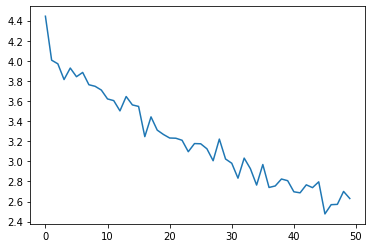

In [10]:
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluation

Now that we have trained our encoder and decoder, we can use them to perform translations! Below, in the "evaluate_randomly" function, we randomly pick a pair of phrases that we have trained on, and see how well we can translate that phrase. 

In [11]:
for_evaluations = (input_lang, output_lang, all_vars_training[0], all_vars_training[1])

In [29]:
def evaluate_randomly():
    pair = random.choice(pairs)
    output_words, decoder_attn = evaluate(pair[0], for_evaluations)
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

You can keep running this cell over and over again to see how well the translator does on various phrases.

In [30]:
evaluate_randomly()

> i am going to start .
= voy a empezar .
< voy a empezar . <EOS>



You can also evaluate the encoder/decoder on phrases that you come up with! Here is an example of how to do that. 
### Note
If you translated from English to another language, the phrases you test have to start with the "good prefixes" and also contain words that the model has seen before. This is why you may get errors if you change the "phrase" below.

If you translated from another language to English, you have to select phrases that start with translated "good prefixes" and also contain translated words the model has seen before.

In [14]:
phrase = 'i m happy .'
output_words, _ = evaluate(phrase, for_evaluations)
output_sentence = ' '.join(output_words)
print('>', phrase)
print('<', output_sentence)

> i m happy .
< estoy feliz . <EOS>
